In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from time import perf_counter 
import os

In [ ]:
## Defining batch specfications
batch_size = 100
img_height = 250
img_width = 250

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## loading training set
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'Datasets/train',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size
)

Found 791 files belonging to 2 classes.


In [ ]:
## loading validation dataset
validation_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    'Datasets/val',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size)


Found 98 files belonging to 2 classes.


In [ ]:
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'Datasets/test',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size)

class_names = training_ds.class_names

## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)



Found 100 files belonging to 2 classes.


In [ ]:
## Defining Cnn
MyCnn = tf.keras.models.Sequential([
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(len(class_names), activation= 'softmax')
])

MyCnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
## lets train our CNN
retVal = MyCnn.fit(training_ds, validation_data= validation_ds, epochs = 10)

Epoch 1/10
8/8 [==============================] - 120s 3s/step - loss: 0.7422 - accuracy: 0.5335 - val_loss: 0.7155 - val_accuracy: 0.4694
Epoch 2/10
8/8 [==============================] - 2s 252ms/step - loss: 0.6900 - accuracy: 0.5234 - val_loss: 0.7147 - val_accuracy: 0.5306
Epoch 3/10
8/8 [==============================] - 2s 254ms/step - loss: 0.6719 - accuracy: 0.5942 - val_loss: 0.6884 - val_accuracy: 0.5612
Epoch 4/10
8/8 [==============================] - 2s 253ms/step - loss: 0.6448 - accuracy: 0.6068 - val_loss: 0.6267 - val_accuracy: 0.6020
Epoch 5/10
8/8 [==============================] - 2s 250ms/step - loss: 0.6141 - accuracy: 0.6473 - val_loss: 0.6424 - val_accuracy: 0.6327
Epoch 6/10
8/8 [==============================] - 2s 246ms/step - loss: 0.5707 - accuracy: 0.6953 - val_loss: 0.6113 - val_accuracy: 0.6735
Epoch 7/10
8/8 [==============================] - 3s 348ms/step - loss: 0.5081 - accuracy: 0.7421 - val_loss: 0.5847 - val_accuracy: 0.7449
Epoch 8/10
8/8 [=====

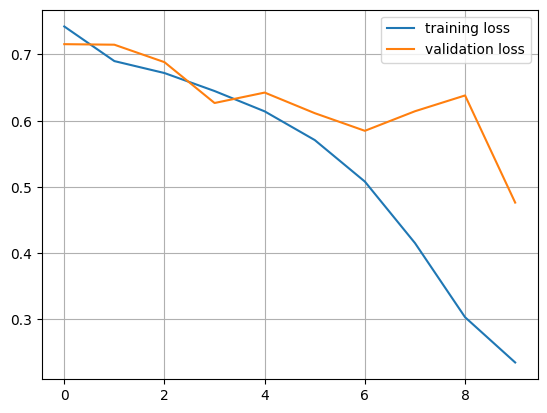

In [ ]:
## stats on training data
plt.plot(retVal.history['loss'], label = 'training loss')
plt.plot(retVal.history['val_loss'], label = 'validation loss')
plt.grid(True)
plt.legend()

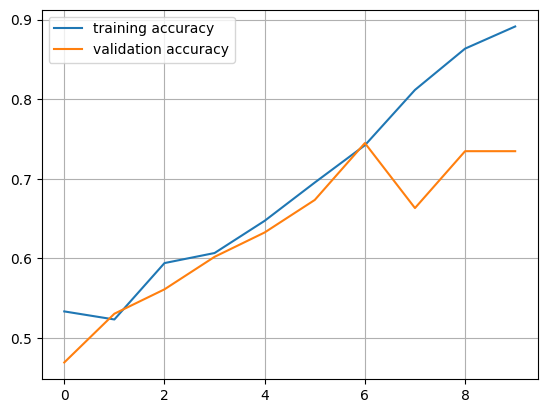

In [ ]:
## stats on validation data
plt.plot(retVal.history['accuracy'], label = 'training accuracy')
plt.plot(retVal.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

4/4 [==============================] - 1s 69ms/step


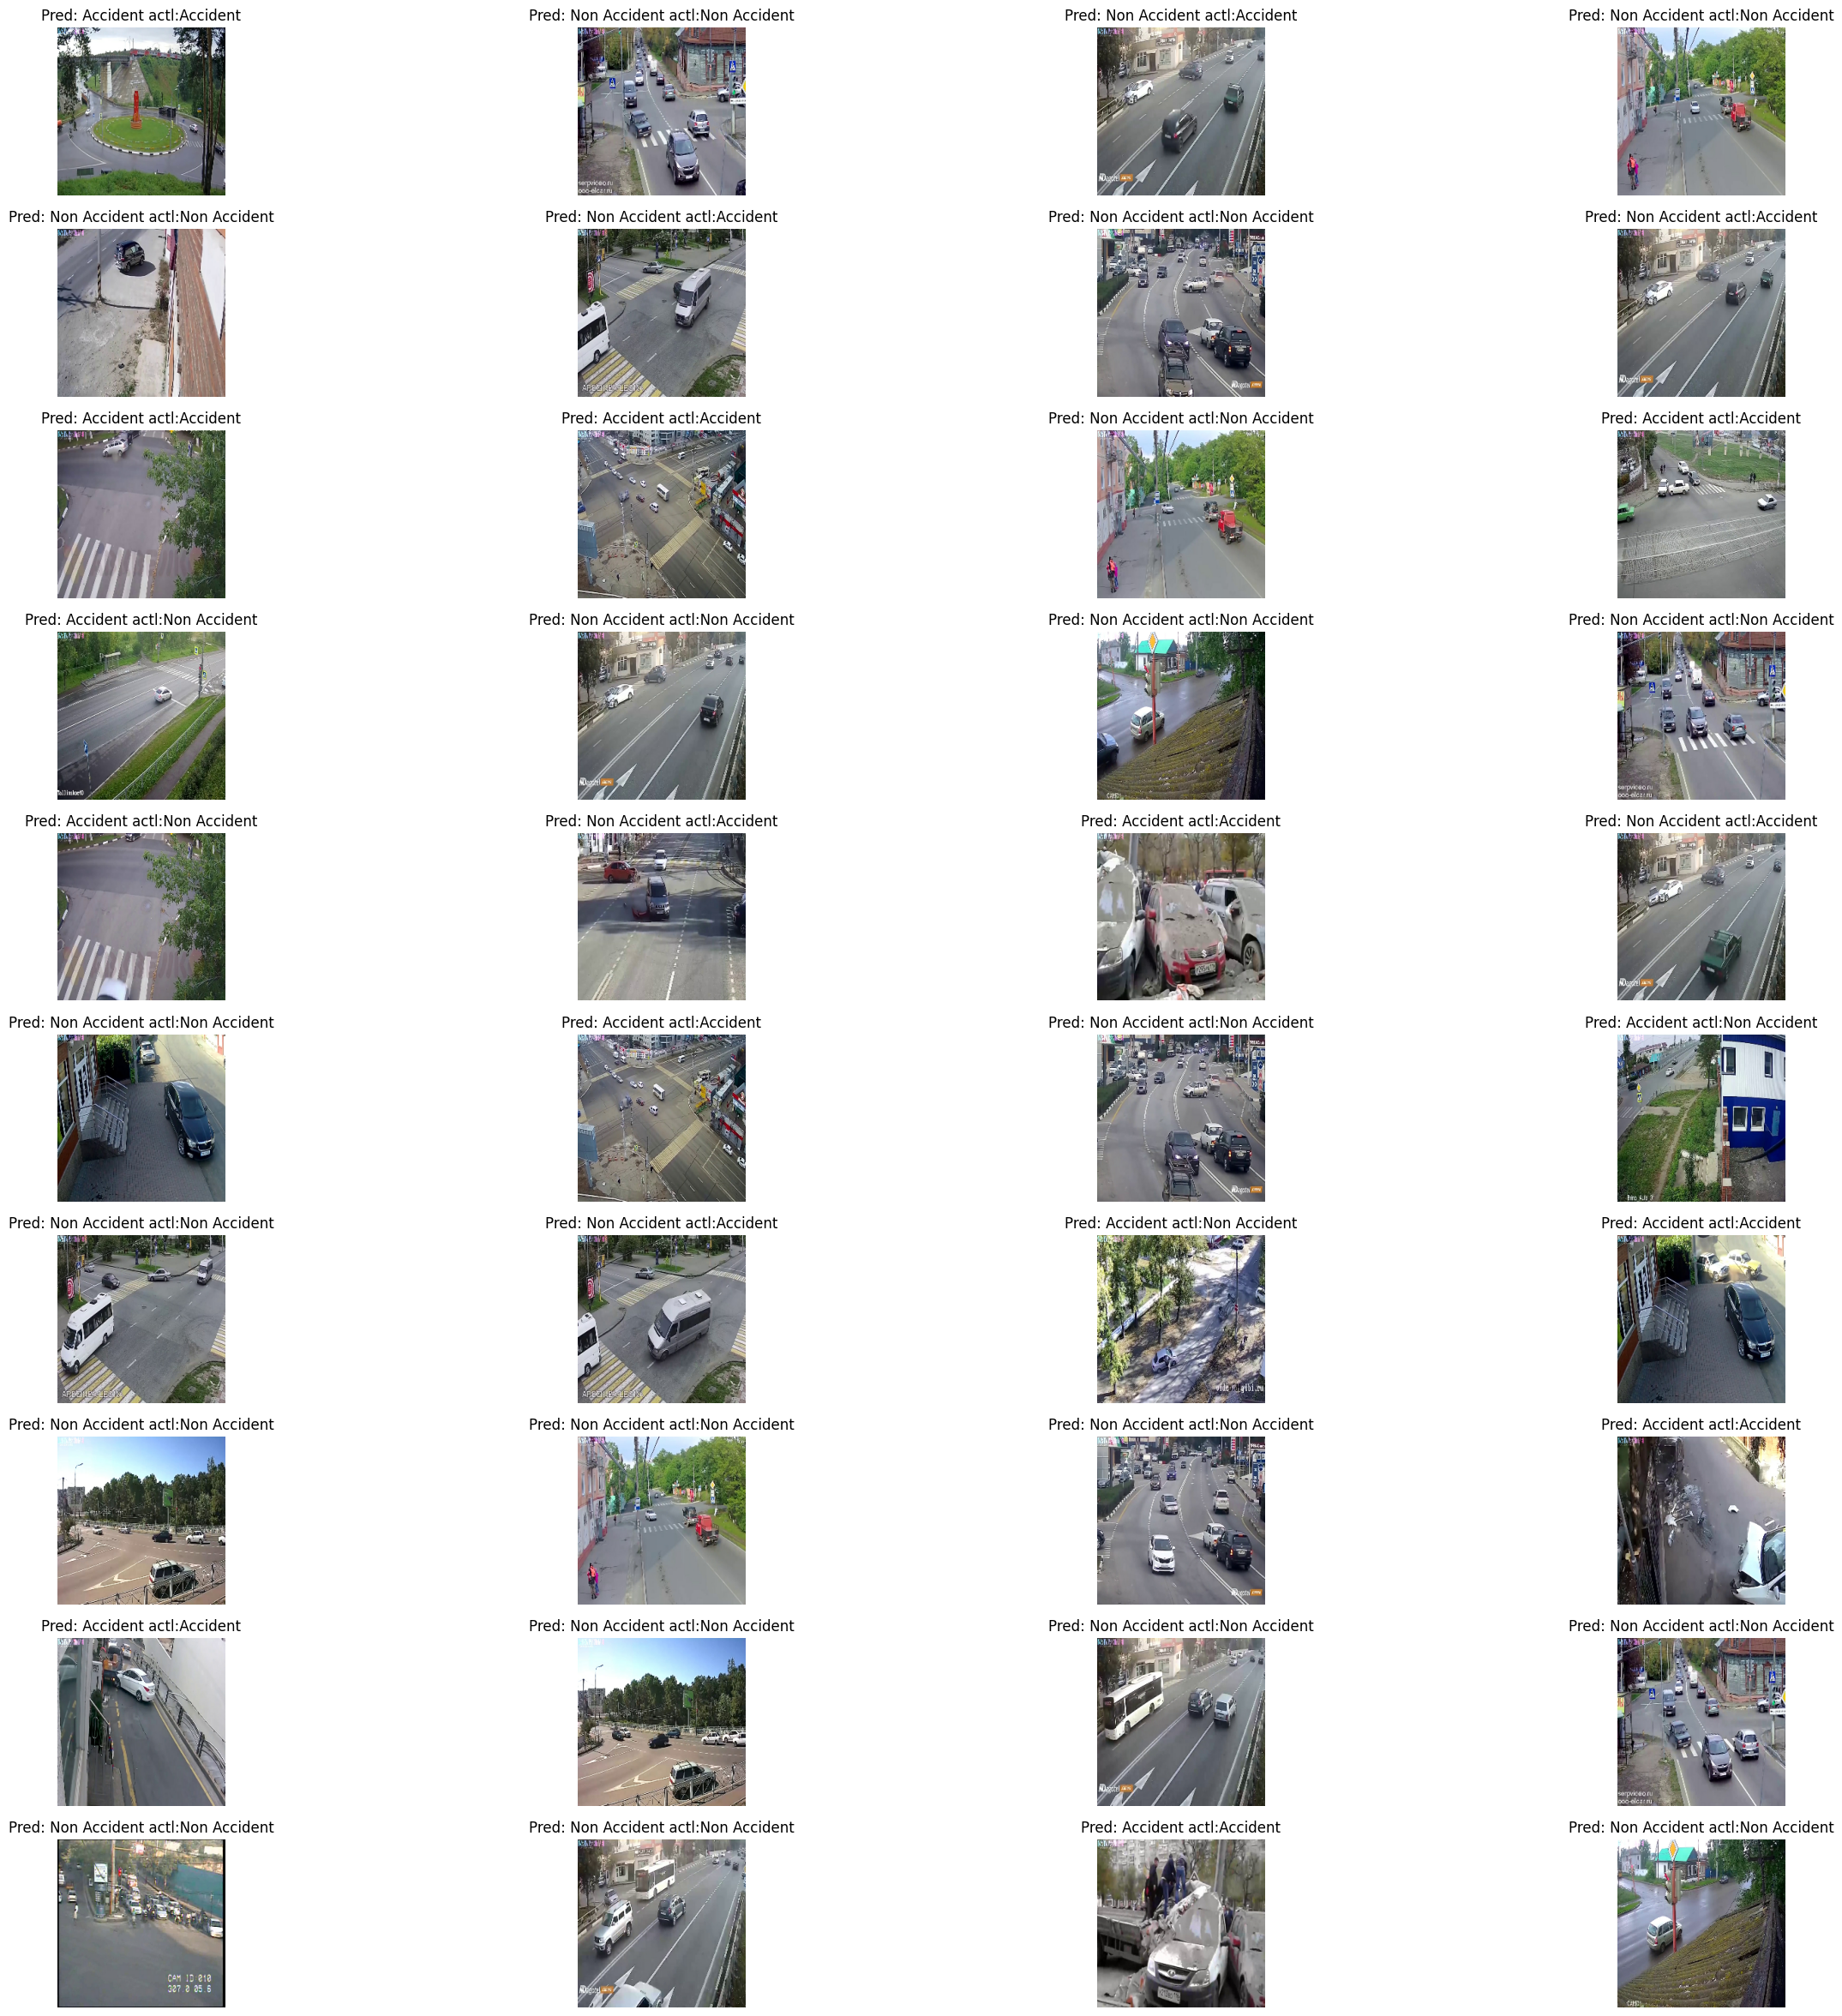

In [ ]:
## lets vizualize results on testing data
AccuracyVector = []
plt.figure(figsize=(30, 30))
for images, labels in testing_ds.take(1):
    predictions = MyCnn.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)

In [ ]:
MyCnn.save('Model.h5')

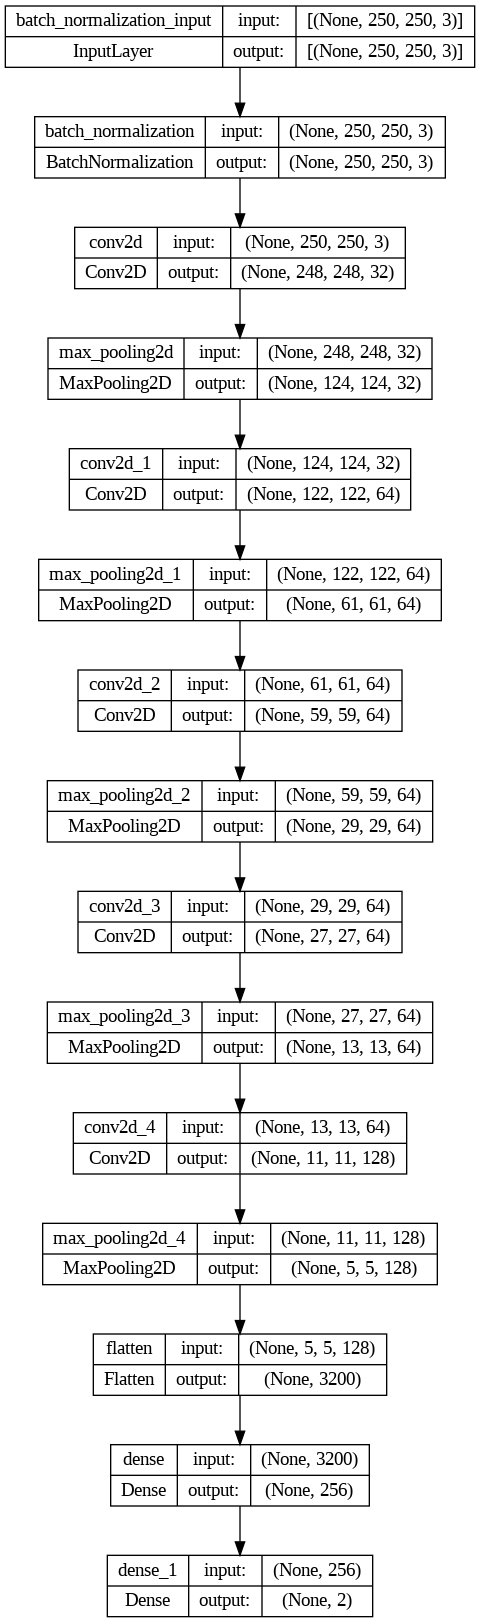

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(MyCnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

mobilnet = VGG16(input_shape= [img_height,img_width] + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in mobilnet.layers:
    layer.trainable = False

In [ ]:
x = layers.Flatten()(mobilnet.output)

In [ ]:
outlayer = layers.Dense(len(class_names), activation= 'softmax')(x)

In [ ]:
from tensorflow.keras.models import Model

model = Model(inputs=mobilnet.input,outputs = outlayer)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 62, 62, 128)       0     

In [ ]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
tfl = model.fit(training_ds,validation_data=validation_ds,epochs=10)

Epoch 1/10
8/8 [==============================] - 44s 4s/step - loss: 9.9055 - accuracy: 0.6587 - val_loss: 3.6810 - val_accuracy: 0.8367
Epoch 2/10
8/8 [==============================] - 5s 663ms/step - loss: 4.0102 - accuracy: 0.8571 - val_loss: 1.9489 - val_accuracy: 0.8878
Epoch 3/10
8/8 [==============================] - 5s 660ms/step - loss: 1.9142 - accuracy: 0.8925 - val_loss: 3.0819 - val_accuracy: 0.8571
Epoch 4/10
8/8 [==============================] - 7s 881ms/step - loss: 1.7607 - accuracy: 0.9077 - val_loss: 1.3835 - val_accuracy: 0.9184
Epoch 5/10
8/8 [==============================] - 5s 667ms/step - loss: 1.3141 - accuracy: 0.9406 - val_loss: 1.7270 - val_accuracy: 0.8980
Epoch 6/10
8/8 [==============================] - 5s 691ms/step - loss: 0.6073 - accuracy: 0.9583 - val_loss: 2.0077 - val_accuracy: 0.9082
Epoch 7/10
8/8 [==============================] - 5s 675ms/step - loss: 0.6435 - accuracy: 0.9709 - val_loss: 0.8361 - val_accuracy: 0.9490
Epoch 8/10
8/8 [======

In [ ]:
model.evaluate(testing_ds)

1/1 [==============================] - 1s 550ms/step - loss: 1.1664 - accuracy: 0.9600


[1.1663808822631836, 0.9599999785423279]

4/4 [==============================] - 7s 482ms/step


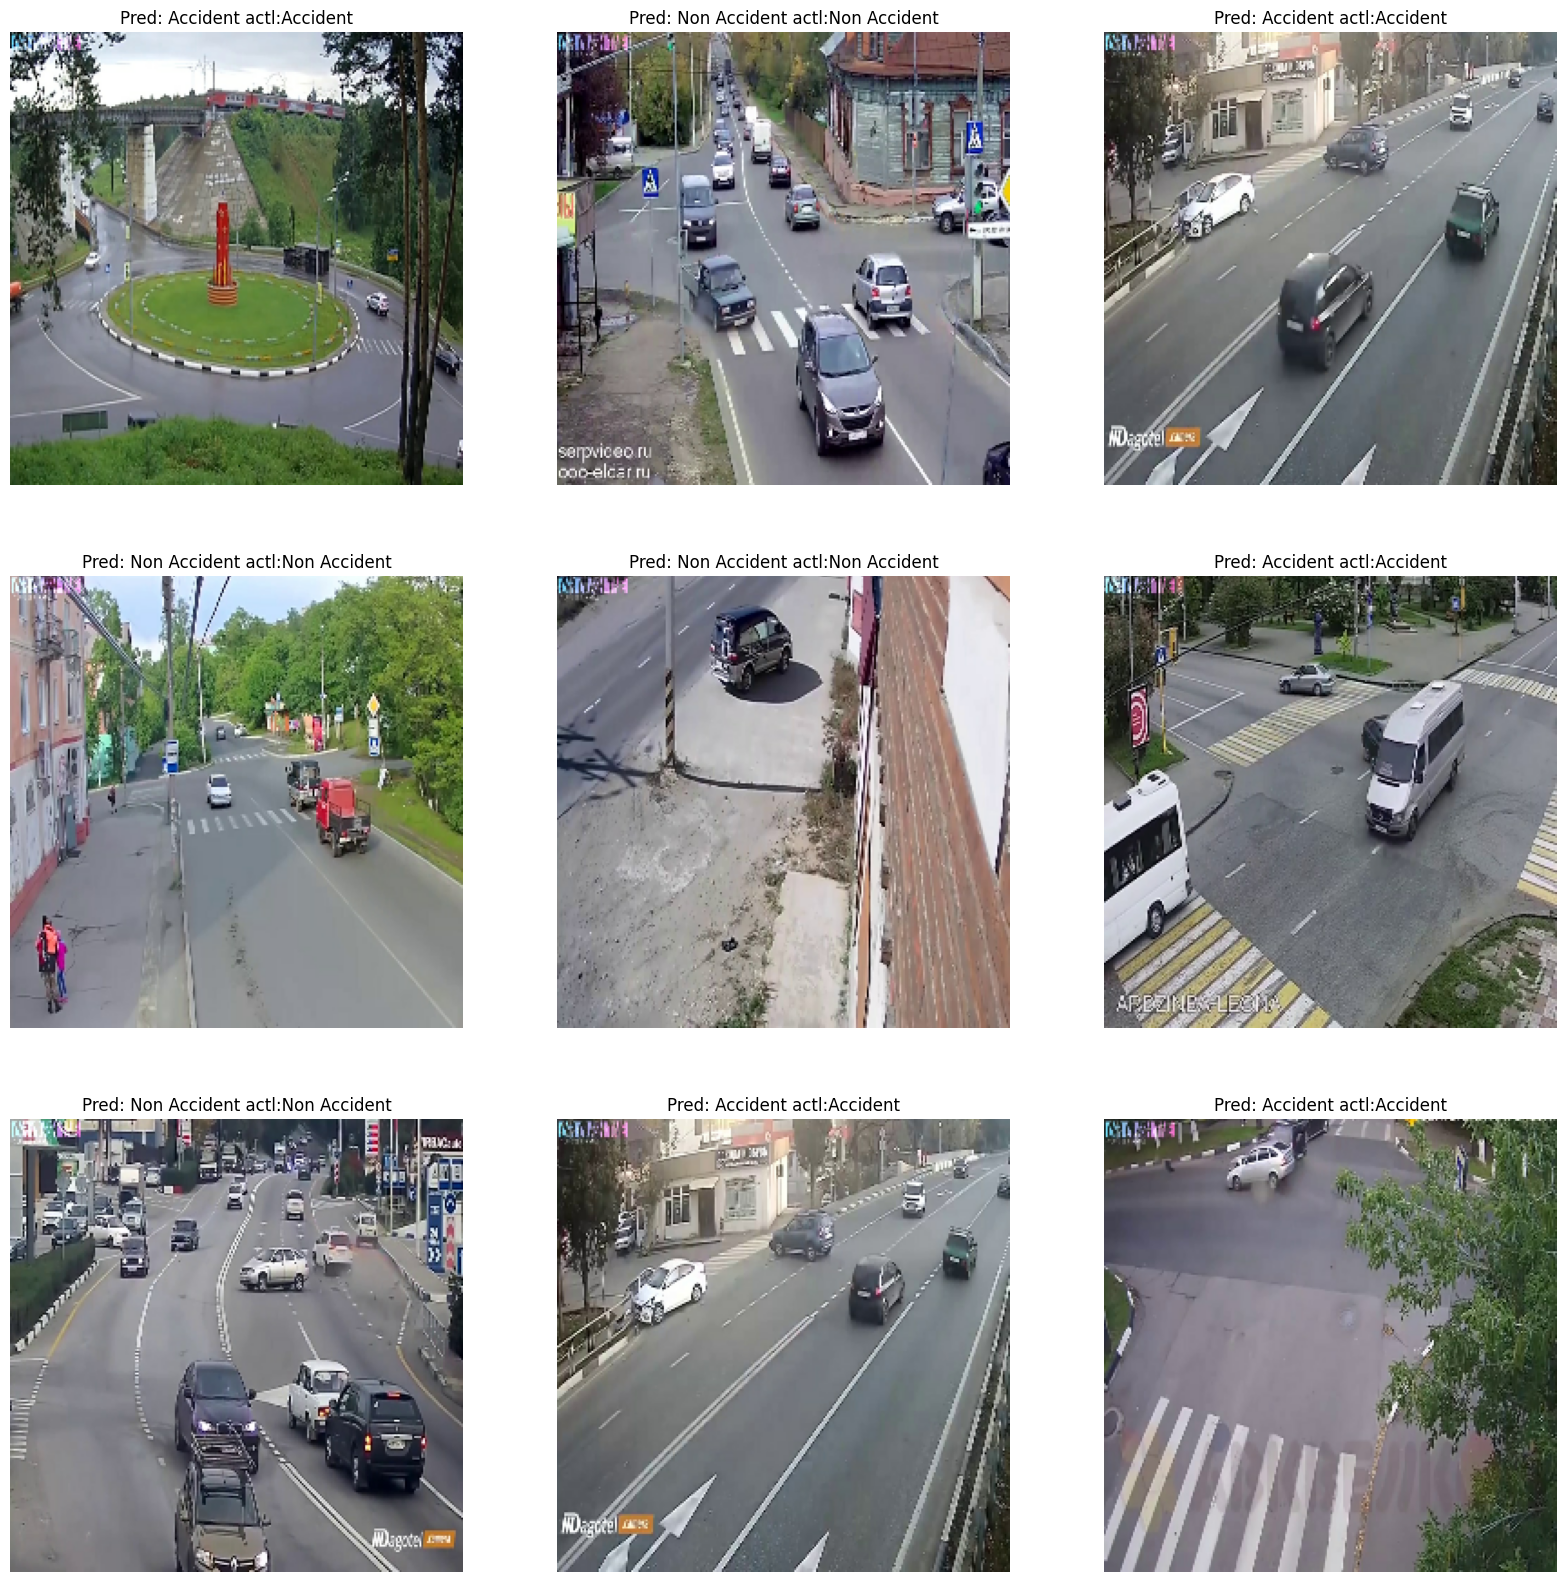

In [ ]:
AccuracyVector = []
plt.figure(figsize=(20, 20))
for images, labels in testing_ds.take(1):
    predictions = model.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)

In [ ]:
model.save('AccidentDetection.h5')